In [1]:
# General python imports
import numpy as np

# Astropy
from astropy.visualization import  ZScaleInterval, AsinhStretch
import astropy.units as u
from astropy.time import Time
from datetime import datetime

import fitsio
from math import ceil
import pandas as pd

# LSST imports
from lsst.daf.butler import Butler
import lsst.geom as geom

import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors

plt.style.use('~/.config/matplotlib/spie-faro.mplstyle')
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

In [2]:
def get_date(visit):
    visit=str(visit)
    year=int(visit[:4])
    month=int(visit[4:6])
    day=int(visit[6:8])
    t = Time(datetime(year, month, day), scale='utc')
    return t.mjd


def cutout_calexp(butler, ra, dec, visit, band='g', detector=0, instrument='LATISS', datasetType='calexp',
                 skymap=None, cutoutSideLength=201, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap", dataId={'skymap':'at_discrete_v2'}, collections=collections)
    calexpId = {'band': band, 'skymap':'at_discrete_v2', 'instrument': instrument, 'detector': detector, 'visit': visit}
    # Look up the tract, patch for the RA, Dec
    wcs=butler.get('calexp.wcs', **calexpId, collections=collections)
    xy = geom.PointI(wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)

    
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              #immediate=True, 
                    
                              dataId=calexpId, collections=collections)

    return cutout_image

def create_stich(visit_list, sub_catalog, butler,columns=3,band="g",cutoutSideLength=100,):
    nvisit=len(visit_list)
    rows=3# ceil(nvisit/columns)
    stich=np.ones((cutoutSideLength*rows +10*(rows-1),cutoutSideLength*columns+10*(columns-1)))*np.nan
    for i in range(rows):
        for j in range(columns):
            if ((columns*i+j)+1 <= len(visit_list)) & ((columns*i+j)+1 <= 9):
                visit=visit_list[columns*i+j]
                #print(i,j)
                row=sub_catalog.loc[(sub_catalog["visit"]==visit),:]
                ra=row["ra"].values
                dec=row["decl"].values
                #ra/dec must be in deg
                print(visit)#, np.round(ra,3),np.round(dec,3))
                cutout=cutout_calexp(butler, ra, dec, visit, band=band, detector=0, instrument='LATISS', datasetType='calexp',
                     skymap=None, cutoutSideLength=cutoutSideLength)
                stich[i*10+i*cutoutSideLength:i*10+(i+1)*cutoutSideLength,
                  j*10+j*cutoutSideLength:j*10+(j+1)*cutoutSideLength]=cutout.image.array
    return stich

In [3]:
def create_catalog(butler, band=["g","r","i"],pixcut=True, collections='isolatedStarAssociation_rerun/20220426T223510Z'):
    ISS_dataid=sorted(butler.registry.queryDatasets('isolated_star_sources', 
                                                    collections=collections))[0].dataId
    catalog=butler.get('isolated_star_sources',dataId=ISS_dataid, collections=collections)
    sel=(catalog["psfFlux"]/catalog["psfFluxErr"] > 50) & (catalog['apFlux_17_0_flag']==0) & np.isin(catalog["band"],band)
    if pixcut:
        sel &= (catalog["y"] > 1000) & (catalog["y"] < 3000)
        sel &= (catalog["x"] > 1000) & (catalog["x"] < 3000)
    catalog=catalog.loc[sel,:]    
    print(len(catalog))
    psfmags = (catalog.loc[:, 'psfFlux'].values*u.nJy).to(u.ABmag).value
    apermags = (catalog.loc[:, 'apFlux_12_0_instFlux'].values*u.nJy).to(u.ABmag).value
    
    catalog = catalog.assign(**{'psfMag': psfmags})
    catalog = catalog.assign(**{'aperMag': apermags})
    magColumn="psfMag"
    catalog.loc[:,"magMean"]=catalog.groupby("obj_index")[magColumn].transform(np.mean)
    catalog.loc[:,"magMedian"]=catalog.groupby("obj_index")[magColumn].transform(np.median)
    catalog.loc[:,"rms"]=catalog.groupby("obj_index")[magColumn].transform(np.nanstd)
    catalog.loc[:,"count"]=catalog.groupby("obj_index")[magColumn].transform(np.count_nonzero)
    catalog.loc[:,"mean_resid"]=catalog.groupby("obj_index")[magColumn].transform(lambda x: np.array(x-np.mean(x)))
    catalog.loc[:,"mean_resid_mmag"]=catalog["mean_resid"]*1e3
    catalog.loc[:,"median_resid"]=catalog.groupby("obj_index")[magColumn].transform(lambda x: np.array(x-np.median(x)))
    catalog.loc[:,"mjd"]=catalog.groupby("visit")["visit"].transform(lambda x: get_date(np.unique(x)[0]))
    
    catalog=catalog.loc[~np.isnan(catalog["rms"]),:]
    print(len(catalog))
    if pixcut:
        catalog=catalog.loc[(catalog["count"] > 6),:]
    catalog=catalog.reset_index()
    return catalog

def scale_image(image):
    transform = AsinhStretch() + ZScaleInterval()
    scaledImage = transform(image)
    scaledImage = np.flipud(scaledImage)
    return scaledImag

In [4]:
repo= "/project/edennihy/auxtelImagingSurveys/data/butler.yaml"
#collection = '2.2i/runs/DP0.1'
butler = Butler(repo)#, collections=collection)
band="g"

In [5]:
collections=sorted(butler.registry.queryCollections())
butler = Butler(repo, collections=collections)
registry=butler.registry

In [6]:
pixcut=False
catalog_g=create_catalog(butler, band="g",pixcut=pixcut)
catalog_r=create_catalog(butler, band="r",pixcut=pixcut)
catalog_i=create_catalog(butler, band="i",pixcut=pixcut)
#catalog=catalog_g.copy()

49544
48631
77471
75954
80571
78557


In [7]:
catalog_g[catalog_g['obj_index'] == 46403][['obj_index', 'rms', 'magMean']]

,obj_index,rms,magMean
48621,46403,0.003482,12.713323
48622,46403,0.003482,12.713323


### Histograms of RMS measurements

In [8]:
pa1g=np.median(catalog_g["rms"]*1e3)
pa1r=np.median(catalog_r["rms"]*1e3)
pa1i=np.median(catalog_i["rms"]*1e3)
print('PA1:$g$',f'{pa1g:5.5f} mmag', 'PA1:$r$', f'{pa1r:5.5f} mmag', 'PA1:$i$', f'{pa1i:5.5f} mmag')

PA1:$g$ 40.56417 mmag PA1:$r$ 25.58958 mmag PA1:$i$ 24.66822 mmag


In [9]:
# from descolors import BAND_COLORS
   
from collections import OrderedDict as odict
BAND_COLORS = odict([
    ('u','#56b4e9'),
    ('g','#008060'),
    ('r','#ff4000'),
    ('i','#850000'),
    ('z','#6600cc'),
    ('Y','#000000'),
])
for name,color in BAND_COLORS.items():
    print("%s : %s"%(name,color))

u : #56b4e9
g : #008060
r : #ff4000
i : #850000
z : #6600cc
Y : #000000


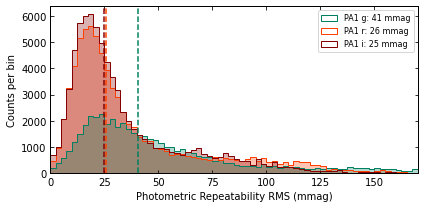

In [10]:
plt.subplots(1,1,figsize=(600*px, 300*px))
#plt.subplots(1,1,figsize=(10, 5))

#plt.subplots(1,1,dpi=125)
# colors=["tab:green","tab:red","tab:purple"]
colors=[BAND_COLORS.get('g'), BAND_COLORS.get('r'), BAND_COLORS.get('i')]
alpa = 0.3
lw=1
plt.subplot(111)
#plt.suptitle("LATISS PA1 - Full Detector", y=0.95)
# histtype="step"

plt.hist(catalog_g["rms"]*1e3, bins=np.arange(0,300,2.5), histtype='step', linewidth=lw, color=colors[0], label=f'PA1 g: {pa1g:0.0f} mmag')
plt.hist(catalog_r["rms"]*1e3, bins=np.arange(0,300,2.5), histtype='step', linewidth=lw, color=colors[1], label=f'PA1 r: {pa1r:0.0f} mmag')
plt.hist(catalog_i["rms"]*1e3, bins=np.arange(0,300,2.5), histtype='step', linewidth=lw, color=colors[2], label=f'PA1 i: {pa1i:0.0f} mmag')


plt.hist(catalog_r["rms"]*1e3, bins=np.arange(0,300,2.5), alpha=alpa, linewidth=lw, color=colors[1], label='__no label__')
plt.hist(catalog_i["rms"]*1e3, bins=np.arange(0,300,2.5), alpha=alpa, linewidth=lw, color=colors[2], label='__no label__')
plt.hist(catalog_g["rms"]*1e3, bins=np.arange(0,300,2.5), alpha=alpa, linewidth=lw, color=colors[0], label='__no label__')

    
plt.axvline(np.median(catalog_r["rms"]*1e3), color=colors[1], ls="dashed", label='_nolegend_')
plt.axvline(np.median(catalog_i["rms"]*1e3), color=colors[2], ls="dashed", label='_nolegend_')
plt.axvline(np.median(catalog_g["rms"]*1e3), color=colors[0], ls="dashed", label='_nolegend_')

# Plot non-visible lines for column layout in lgend
plt.plot(np.nan, np.nan, '.', ms=0)
plt.plot(np.nan, np.nan, '.', ms=0)
plt.plot(np.nan, np.nan, '.', ms=0)
# plt.legend(['PA1 g:', 'PA1 r:', 'PA1 i:',
#             f'{pa1g:0.0f} mmag', f'{pa1r:0.0f} mmag', f'{pa1i:0.0f} mmag'],
#              ncol=2, columnspacing=-2.5)
plt.legend()
plt.xlabel("Photometric Repeatability RMS (mmag)")
plt.ylabel("Counts per bin")
plt.xticks(np.arange(0,300,25))
plt.xlim(0,170)
plt.yscale("linear")

ax = plt.gca()
# ax.xaxis.get_major_ticks()[0].set_visible(False)
# ax.yaxis.get_major_ticks()[0].set_visible(False)

plt
plt.savefig("./pa1_auxtel.png", facecolor="white", dpi=300)

### Central Sources Only ###

In [11]:
pixcut=True
catalog_g_central=create_catalog(butler, band="g",pixcut=pixcut)
catalog_r_central=create_catalog(butler, band="r",pixcut=pixcut)
catalog_i_central=create_catalog(butler, band="i",pixcut=pixcut)

14075
13625
22159
21407
23470
22509


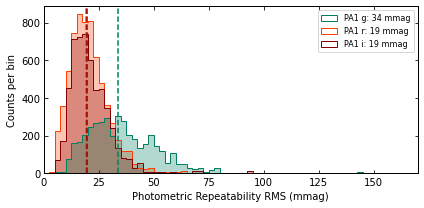

In [12]:
plt.subplots(figsize=(600*px, 300*px))

#plt.subplots(1,1,dpi=125)
#colors=["tab:green","tab:red","tab:purple"]
plt.subplot(111)
#plt.suptitle("LATISS PA1 - Central Detector Region", y=0.95)
pa1g=np.median(catalog_g_central["rms"]*1e3)
pa1r=np.median(catalog_r_central["rms"]*1e3)
pa1i=np.median(catalog_i_central["rms"]*1e3)

plt.hist(catalog_g_central["rms"]*1e3, bins=np.arange(0,300,2.5), histtype='step', linewidth=lw, color=colors[0], label=f'PA1 g: {pa1g:0.0f} mmag')
plt.hist(catalog_r_central["rms"]*1e3, bins=np.arange(0,300,2.5), histtype='step', linewidth=lw, color=colors[1], label=f'PA1 r: {pa1r:0.0f} mmag')
plt.hist(catalog_i_central["rms"]*1e3, bins=np.arange(0,300,2.5), histtype='step', linewidth=lw, color=colors[2], label=f'PA1 i: {pa1i:0.0f} mmag')

plt.hist(catalog_r_central["rms"]*1e3, bins=np.arange(0,300,2.5), alpha=alpa, linewidth=lw, color=colors[1], label='__no label__')

plt.hist(catalog_i_central["rms"]*1e3, bins=np.arange(0,300,2.5), alpha=alpa, linewidth=lw, color=colors[2], label='__no label__')

plt.hist(catalog_g_central["rms"]*1e3, bins=np.arange(0,300,2.5), alpha=alpa, linewidth=lw, color=colors[0], label='__no label__')


plt.axvline(np.median(catalog_r_central["rms"]*1e3), color=colors[1], ls="dashed", label='_nolegend_')
plt.axvline(np.median(catalog_i_central["rms"]*1e3), color=colors[2], ls="dashed", label='_nolegend_')
plt.axvline(np.median(catalog_g_central["rms"]*1e3), color=colors[0], ls="dashed", label='_nolegend_')

# Plot non-visible lines for column layout in lgend
plt.plot(np.nan, np.nan, '.', ms=0)
plt.plot(np.nan, np.nan, '.', ms=0)
plt.plot(np.nan, np.nan, '.', ms=0)
plt.legend()
plt.xlabel("Photometric Repeatability RMS (mmag)")
plt.ylabel("Counts per bin")
plt.xticks(np.arange(0,300,25))
plt.xlim(0,170)
plt.yscale("linear")
plt.savefig("./pa1_auxtel_central.png" , facecolor="white", dpi=300)